In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
from openTSNE import TSNE
import lpips

from utils_evaluate_model import *

## 1) Wasserstein vs Sliced Wasserstein

In [3]:
emd_time = []
sliced_wass_time = []

xx = [10,50,100,500,1000,2000,5000,10000]

for n_points in xx:

  X = np.random.normal(loc=0, scale=1, size=(n_points, 2048))
  Y = np.random.normal(loc=10, scale=1, size=(n_points, 2048))

  a = np.ones((n_points,)) / n_points
  b = np.ones((n_points,)) / n_points

  t1 = time()
  M = ot.dist(X, Y, metric='euclidean')
  emd2 = ot.emd2(a, b, M)
  t2=time()

  t3 = time()
  sliced_wass = ot.sliced_wasserstein_distance(X,Y,a, b, n_projections=100,p=2)
  t4 = time()

  emd_time.append(t2-t1)
  sliced_wass_time.append(t4-t3)

/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


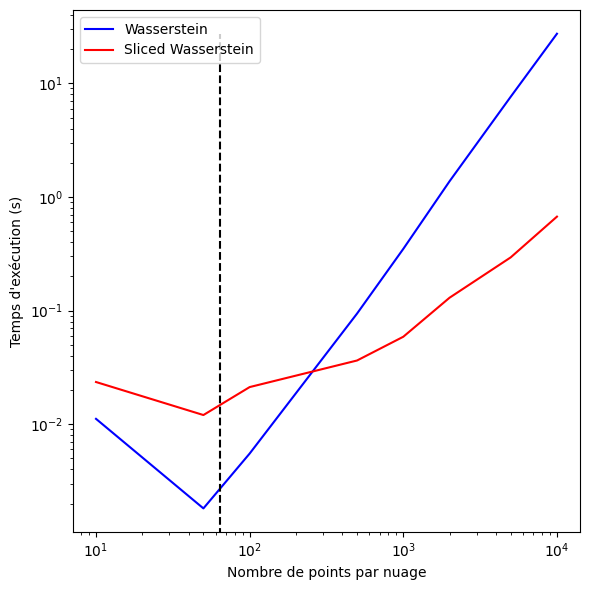

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.plot(xx,emd_time,label='Wasserstein',color='blue')
ax.plot(xx,sliced_wass_time,label='Sliced Wasserstein',color='red')
ax.vlines(x=64,ymin=0,ymax=max(max(emd_time),max(sliced_wass_time)),colors='black',linestyles='dashed')
ax.set_xlabel('Nombre de points par nuage')
ax.set_ylabel('Temps d\'exécution (s)')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## 2) t-SNE visualisation

In [6]:
model = load_inception()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 155MB/s] 


In [7]:
DIRECTORY = "birds"

In [9]:
batch = torch.zeros((50,3,299,299))

for i in range(50):
  batch[i] = preprocess_image(f"{DIRECTORY}/{i}.png")

output = model(batch)

nuages = output.view(50,2048,64).T.detach().numpy()

/tmp/ipython-input-9-2345267442.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  nuages = output.view(50,2048,64).T.detach().numpy()


In [10]:
real_batch = preprocess_image(f"{DIRECTORY}/real.png")

real_nuage = model(real_batch)[0].view(2048, 64).T.detach().numpy()

In [11]:
tsne = TSNE(
    n_components=2,
    perplexity=21,
    metric="euclidean",
    n_jobs=-1,
    random_state=42,
    verbose=False,
)

embedding_X = tsne.fit(real_nuage)
nuages_transformed_2d = np.zeros((50,64,2))

real_transformed_2d = embedding_X.transform(real_nuage)
for i in range(50):
  nuages_transformed_2d[i] = embedding_X.transform(nuages[:,:,i])

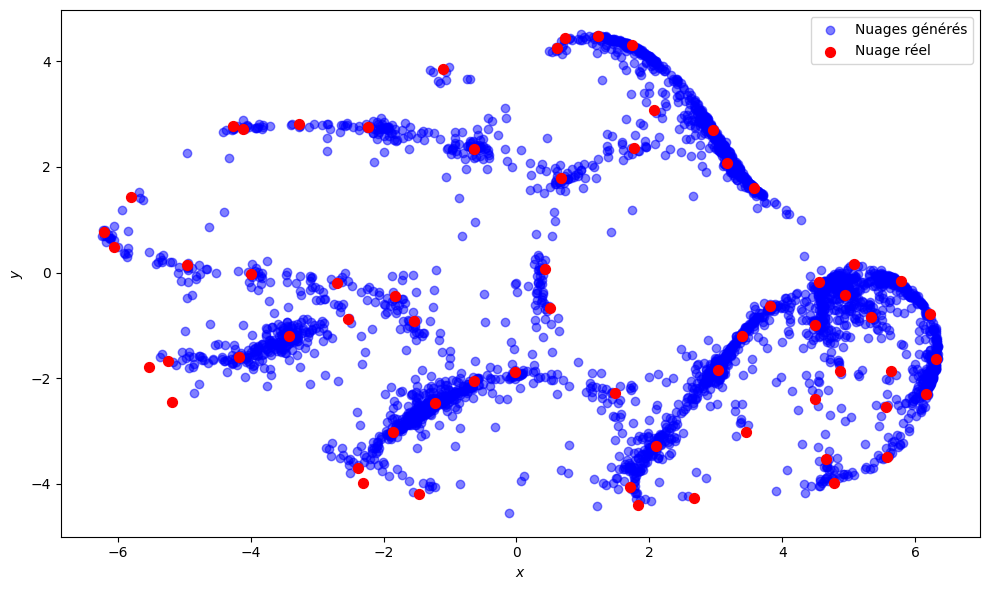

In [12]:
plt.figure(figsize=(10, 6))
for i in range(50):
  if i==0:
    plt.scatter(nuages_transformed_2d[i][:, 0], nuages_transformed_2d[i][:, 1],c='blue',label='Nuages générés',alpha=0.5)
  else:
    plt.scatter(nuages_transformed_2d[i][:, 0], nuages_transformed_2d[i][:, 1],c='blue',alpha=0.5)
plt.scatter(real_transformed_2d[:, 0], real_transformed_2d[:, 1], c='red', label='Nuage réel', s=50)

#plt.title('Nuages après application de TSNE')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.legend()

In [13]:
tsne = TSNE(
    n_components=3,
    perplexity=21,
    metric="euclidean",
    n_jobs=-1,
    random_state=42,
    verbose=False,
)

embedding_X = tsne.fit(real_nuage)
nuages_transformed_3d = np.zeros((50,64,3))

real_transformed_3d = embedding_X.transform(real_nuage)

for i in range(50):
  nuages_transformed_3d[i] = embedding_X.transform(nuages[:,:,i])

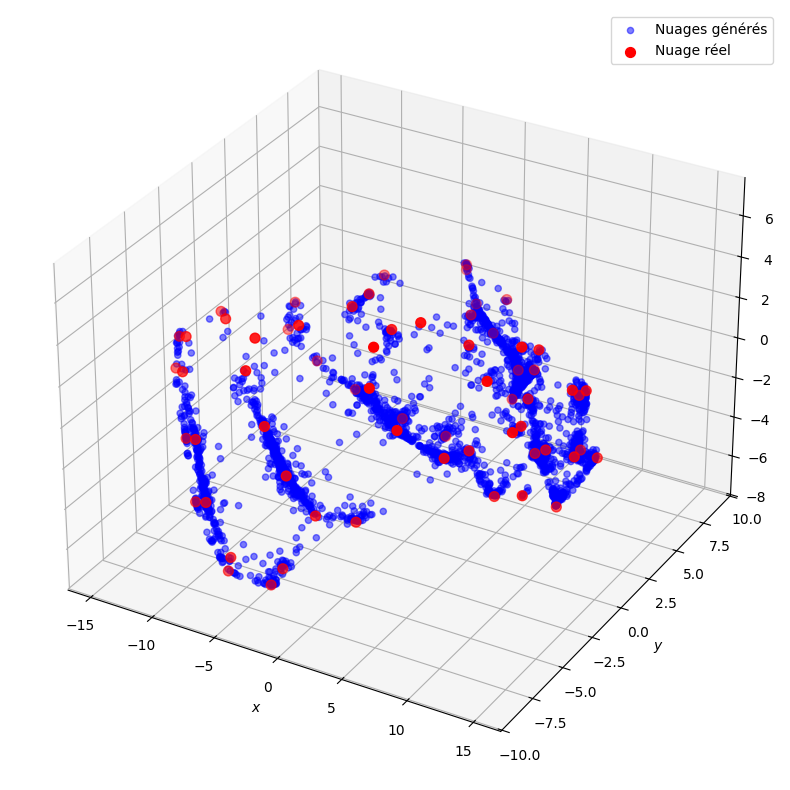

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(50):
  if i==0:
    ax.scatter(nuages_transformed_3d[i][:, 0], nuages_transformed_3d[i][:, 1], nuages_transformed_3d[i][:,2],c='blue',label='Nuages générés',alpha=0.5)
  else:
    ax.scatter(nuages_transformed_3d[i][:, 0], nuages_transformed_3d[i][:, 1], nuages_transformed_3d[i][:,2],c='blue',alpha=0.5)

ax.scatter(real_transformed_3d[:, 0], real_transformed_3d[:, 1], real_transformed_3d[:,2], c='red', label='Nuage réel', s=50)

#plt.title('Nuages après application de TSNE')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.legend()

plt.tight_layout()
plt.show()

## 3) Compute Wasserstein distances

In [15]:
was_distances = np.zeros((50,))

for i in range(50):
  was_distances[i] = wasserstein_image(model, f"{DIRECTORY}/{i}.png", f"{DIRECTORY}/real.png", verbose=False)

In [16]:
print(f"Stats Wasserstein : {was_distances.mean()}, {was_distances.std()}, {was_distances.min()}, {was_distances.max()}")

Stats Wasserstein : 26.05068328499794, 2.445454784073026, 22.97050891071558, 33.46781464666128


## 4) Compute LPIPS distances

In [17]:
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.6MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [19]:
img_real = preprocess_image_for_lpips(f"{DIRECTORY}/real.png")

In [20]:
lpips_distances = np.zeros((50,))

for i in range(50):
  img_generated = preprocess_image_for_lpips(f"{DIRECTORY}/{i}.png")

  lpips_distances[i] = loss_fn_vgg(img_generated, img_real).item()

In [21]:
print(f"Stats LPIPS : {lpips_distances.mean()}, {lpips_distances.std()}, {lpips_distances.min()}, {lpips_distances.max()}")

Stats LPIPS : 0.37330778181552887, 0.02149684278180914, 0.3149172067642212, 0.418024480342865
